# Mintpy Time Series
George Brencher

In [1]:
# Clone MintPy, create environment, install MintPy. Environment creation takes 10-15 min
# git clone https://github.com/insarlab/MintPy.git
!mamba env create -f MintPy/docs/environment.yml
!conda activate mintpy
!python -m ipykernel install --user --name=mintpy


CondaValueError: prefix already exists: /srv/conda/envs/mintpy


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


Installed kernelspec mintpy in /home/jovyan/.local/share/jupyter/kernels/mintpy


In [2]:
# Import required packages
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import mintpy
from mintpy.objects import ifgramStack
from mintpy.utils import plot as pp, utils as ut
from mintpy import view, plot_network
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity

In [3]:
# download example dataset, since topsStack is not working correctly
if not os.path.exists('/tmp/data'):
        os.makedirs('/tmp/data')

os.chdir('/tmp/data')

In [4]:
# grabbing example interferogram stack
url = 'https://zenodo.org/record/3952953/files/FernandinaSenDT128.tar.xz'
tar_file = os.path.basename(url)
proj_name = tar_file.split('.')[0]
if not os.path.isfile(tar_file):
    !wget {url}
else:
    print('{} exists, skip re-download.'.format(tar_file))

# uncompress example dataset
if not os.path.isdir(proj_name):
    print('uncompressing the tar file ...')
    !tar -xJf {tar_file}

FernandinaSenDT128.tar.xz exists, skip re-download.


In [5]:
# create directory for MintPy
os.chdir('/tmp')

if not os.path.exists('/tmp/mintpy'):
        os.makedirs('/tmp/mintpy')

os.chdir('/tmp/mintpy')

In [6]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process ISCE products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [7]:
# Write config file for MintPy. Needs to be parameterized with paths and desired options.
# For a list of processing options, see: 
#https://nbviewer.org/github/insarlab/MintPy-tutorial/blob/main/smallbaselineApp.ipynb
CONFIG_TXT = '''# vim: set filetype=cfg:
##----------------------------- SentinelStack/ISCE ---------------------##
#ssaraopt = --platform=SENTINEL-1A,SENTINEL-1B -r 128 -f 589,590,591,592,593  -e 2017-07-01
#sentinelStack.boundingBox      = '-1 0.15 -91.6 -90.9'
#sentinelStack.subswath         = 1 2     # comment 
#sentinelStack.numConnections   = 5       # comment
#sentinelStack.azimuthLooks     = 5       # comment
#sentinelStack.rangeLooks       = 15      # comment
#sentinelStack.filtStrength     = 0.2     # comment
#sentinelStack.unwMethod        = snaphu  # comment
#sentinelStack.coregistration   = auto    # comment
#subset.y0:y1,x0:x1 = 1150:1600,1070:1670

##-------------------------------- MintPy -----------------------------##
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = ../data/FernandinaSenDT128/reference/IW*.xml
mintpy.load.baselineDir      = ../data/FernandinaSenDT128/baselines
##---------interferogram datasets:
mintpy.load.unwFile          = ../data/FernandinaSenDT128/merged/interferograms/*/filt_*.unw
mintpy.load.corFile          = ../data/FernandinaSenDT128/merged/interferograms/*/filt_*.cor
mintpy.load.connCompFile     = ../data/FernandinaSenDT128/merged/interferograms/*/filt_*.unw.conncomp
##---------geometry datasets:
mintpy.load.demFile          = ../data/FernandinaSenDT128/merged/geom_reference/hgt.rdr
mintpy.load.lookupYFile      = ../data/FernandinaSenDT128/merged/geom_reference/lat.rdr
mintpy.load.lookupXFile      = ../data/FernandinaSenDT128/merged/geom_reference/lon.rdr
mintpy.load.incAngleFile     = ../data/FernandinaSenDT128/merged/geom_reference/los.rdr
mintpy.load.azAngleFile      = ../data/FernandinaSenDT128/merged/geom_reference/los.rdr
mintpy.load.shadowMaskFile   = ../data/FernandinaSenDT128/merged/geom_reference/shadowMask.rdr
mintpy.load.waterMaskFile    = None

mintpy.reference.lalo        = -0.30,-91.43
mintpy.topographicResidual.stepFuncDate  = 20170910,20180613  #eruption dates
mintpy.deramp                = linear
'''

config_file = os.path.join('/tmp/mintpy', "FernandinaSenDT128.txt")
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /tmp/mintpy/FernandinaSenDT128.txt


In [8]:
# View MintPy options
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

In [9]:
# Load data into MintPy
!smallbaselineApp.py FernandinaSenDT128.txt --dostep load_data

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:14:56.823656--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
copy FernandinaSenDT128.txt to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy FernandinaSenDT128.txt to pic      directory for backup.
read default template file: /tmp/mintpy/sma

In [10]:
# Examine loaded inputs to MintPy
!ls -l inputs

total 644820
-rw-r--r-- 1 jovyan jovyan      2139 Mar 16 22:14 FernandinaSenDT128.txt
-rw-r--r-- 1 jovyan jovyan   4133188 Mar 16 18:44 geometryRadar.h5
-rw-r--r-- 1 jovyan jovyan 656123122 Mar 16 18:44 ifgramStack.h5
-rw-r--r-- 1 jovyan jovyan     21902 Mar 16 18:44 smallbaselineApp.cfg


run view.py in MintPy version v1.3.2, date 2021-11-21
input file is ifgramStack file: /tmp/mintpy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (450, 600)
input dataset: "['20180526_20180619']"
num of datasets in file ifgramStack.h5: 864
num of datasets to exclude: 0
num of datasets to display: 3
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: viridis
DESCENDING orbit -> flip left-right
figure title: unwrapPhase
figure size : [15.00, 8.00]
dataset number: 3
row     number: 1
column  number: 3
figure  number: 1
consider reference pixel in y/x: [76, 156]
mark interferograms with 'dropIfgram=False' in red colored title
----------------------------------------
Figure 1 - unwrapPhase.png
reading data as a list of 2D matrices ...
[==================================================] connectComponent-2

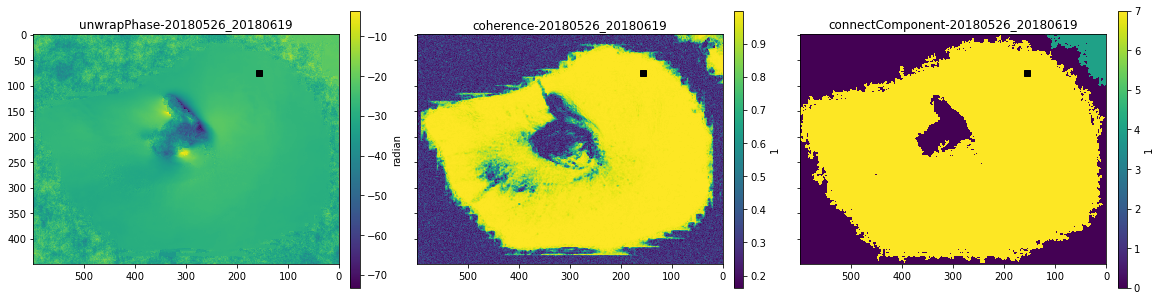

In [11]:
# Plot all data related to one interferometric pair using MintPy plotting utility
view.main('./inputs/ifgramStack.h5 20180526_20180619 --ncols 3 -c viridis'.split())

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is geometry file: /tmp/mintpy/inputs/geometryRadar.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file geometryRadar.h5: 7
datasets to exclude (0):
[]
datasets to display (7):
['azimuthAngle', 'height', 'incidenceAngle', 'latitude', 'longitude', 'shadowMask', 'slantRangeDistance']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: viridis
DESCENDING orbit -> flip left-right
figure title: geometryRadar
figure size : [15.00, 8.00]
dataset number: 7
row     number: 2
column  number: 4
figure  number: 1
----------------------------------------
Figure 1 - geometryRadar.png
reading data as a list of 2D matrices ...
[==================================================] slantRangeDistance     0s  0s 
plotting ...
[==================

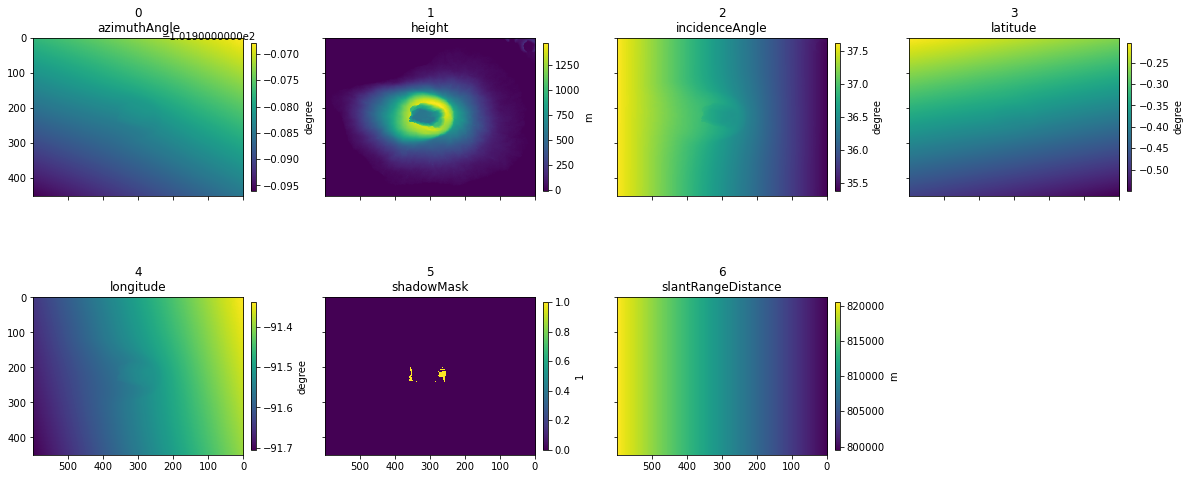

In [12]:
# Examine radar geometry files
view.main('./inputs/geometryRadar.h5 -c viridis'.split())

In [13]:
# Optional step prior to inversion. Remove interferograms based on coherence, temporal/perpendicular baselines, date, etc. 
!smallbaselineApp.py FernandinaSenDT128.txt --dostep modify_network

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:04.513749--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - modify_network ********************

modify_network.py /tmp/mintpy/inputs/ifgramStack.h5 -t /tmp/mintpy/smallbaselineApp.cfg
read options from templa

read temporal/spatial baseline info from file: ./inputs/ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['./inputs/ifgramStack.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 98
number of interferograms: 288
shift all perp baseline by 79.77201843261719 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 288
number of acquisitions marked as drop: 0
max perpendicular baseline: 214.31 m
max temporal      baseline: 96.0 days
showing coherence
data range: [0.6872, 0.7561]
display range: (0.2, 1.0)
showing ...


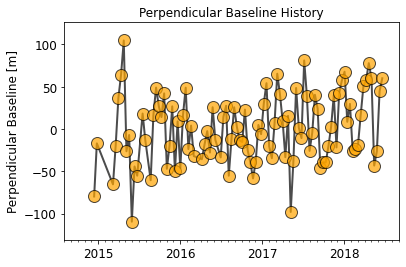

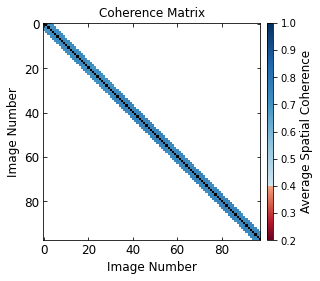

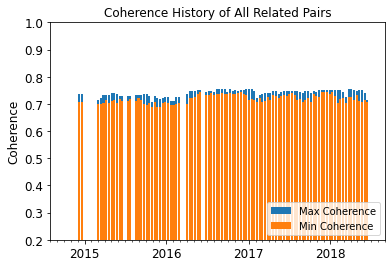

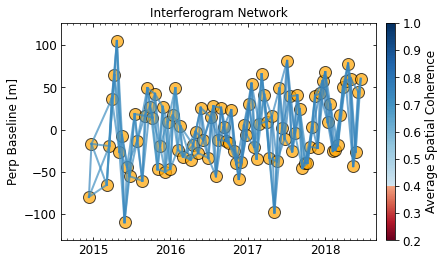

In [14]:
# Examine interferogram network using MintPy tool
plot_network.main(['./inputs/ifgramStack.h5'])

In [15]:
# Select reference point. Should be coherent and close to the aoi. 
!smallbaselineApp.py FernandinaSenDT128.txt --dostep reference_point

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:09.231934--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - reference_point ********************

generate_mask.py /tmp/mintpy/inputs/ifgramStack.h5 --nonzero -o /tmp/mintpy/maskConnComp.h5 --update
input ifgramStack file: /tmp

In [16]:
# Without inversion, quickly assesses possible deformation and phase unwrapping error
!smallbaselineApp.py FernandinaSenDT128.txt --dostep quick_overview

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:12.308854--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - quick_overview ********************

temporal_average.py /tmp/mintpy/inputs/ifgramStack.h5 --dataset unwrapPhase -o /tmp/mintpy/avgPhaseVelocity.h5 --update
output file: /tmp/mintpy/avgP

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is velocity file: /tmp/mintpy/avgPhaseVelocity.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file avgPhaseVelocity.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: RdBu
DESCENDING orbit -> flip left-right
figure title: avgPhaseVelocity
figure size : [10.00, 6.00]
reading data ...
data    range: [-7.713094, 13.292522] cm/year
display range: [-10.0, 10.0] cm/year
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting Data ...
plot reference point
flip figure left and right
showing ...


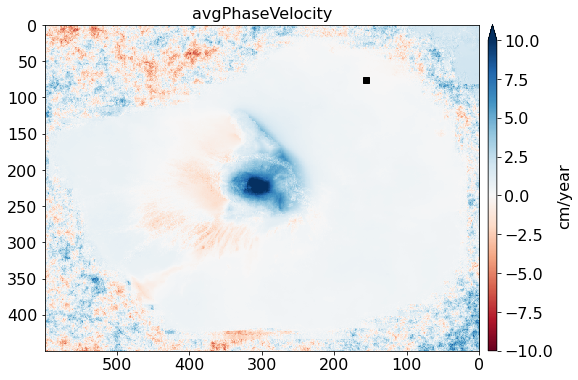

In [17]:
# Plot results of phase stacking 
view.main('avgPhaseVelocity.h5 -c RdBu -v -10 10'.split())

plot and save figure to file numTriNonzeroIntAmbiguity.png


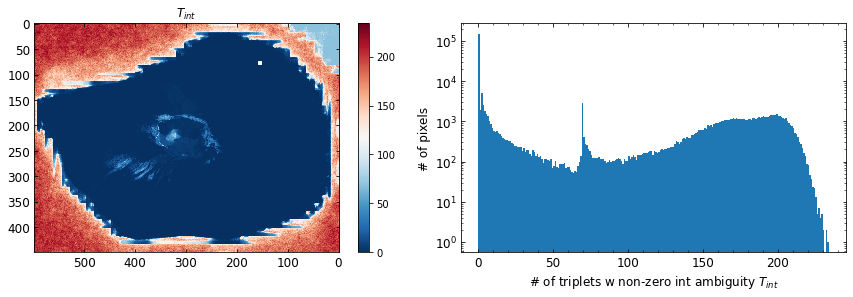

In [18]:
# Plot number of triplets with nonzero integer ambiguity, related to unwrapping error
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[12, 4])

In [19]:
# Do time series inversion. 
!smallbaselineApp.py FernandinaSenDT128.txt --dostep invert_network

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:18.510177--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - invert_network ********************

ifgram_inversion.py /tmp/mintpy/inputs/ifgramStack.h5 -t /tmp/mintpy/smallbaselineApp.cfg --update
use dataset "unwrapPhase" by default
--------------------------------------------------
upda

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is timeseries file: /tmp/mintpy/timeseries.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-20160113', 'timeseries-20160125', 'timeseries-20160206', 'timeseries-20160218', 'timeseries-20160301', 'timeseries-20160406', 'timeseri

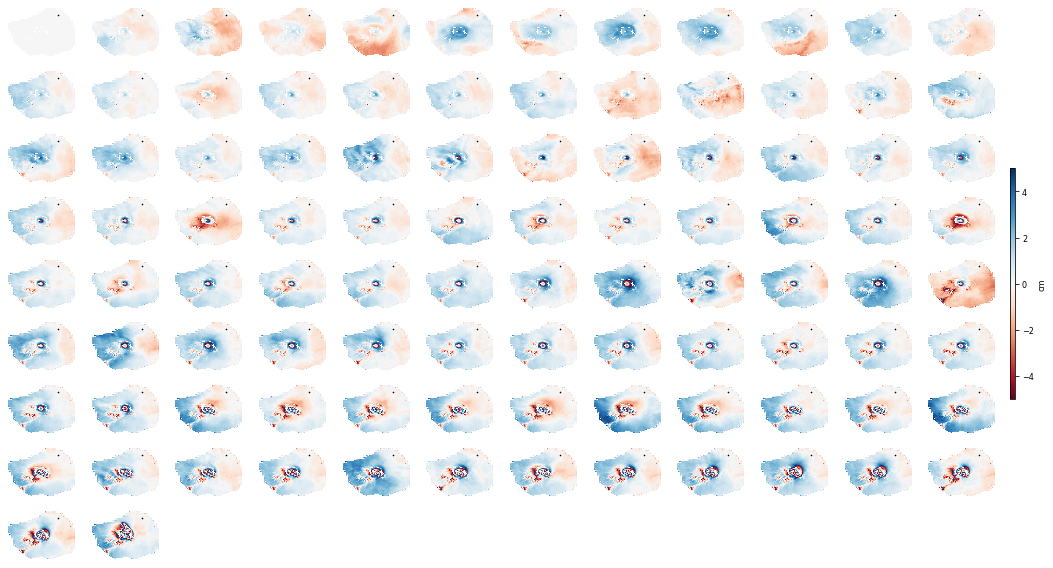

In [20]:
# Plot the raw phase time-series re-wrapped into (-5, 5) cm
view.main('timeseries.h5 --wrap --wrap-range -5 5 -u cm --notitle --notick --noaxis -c RdBu -v -5 5'.split())

view.py temporalCoherence.h5 -c gray --notick --noaxis --noverbose


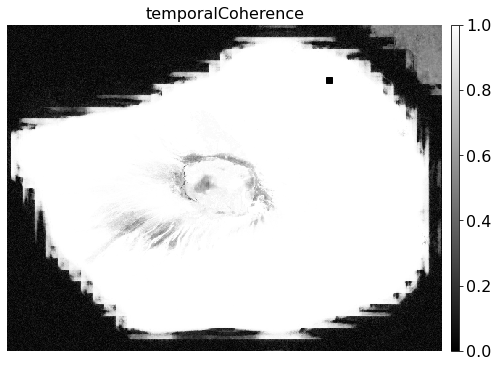

view.py maskTempCoh.h5 -c gray --notick --noaxis --noverbose


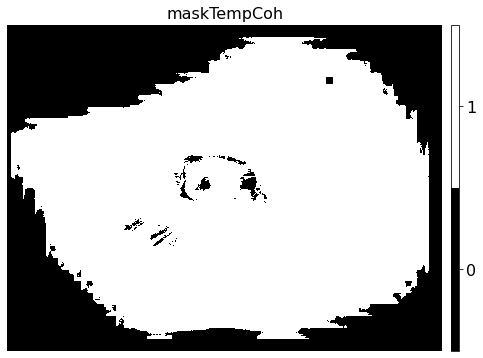

In [21]:
# Plot time series temporal coherence and mask coherence 
view.main('temporalCoherence.h5 -c gray --notick --noaxis --noverbose'.split())
view.main('maskTempCoh.h5 -c gray --notick --noaxis --noverbose'.split())

In [22]:
# Correct for tropospheric correction. Copernicus Climate Data Store (CDS) registration is needed to access ERA5 data. 
# To create account and set up api, follow steps at https://github.com/insarlab/pyaps#2-account-setup-for-era5
# atmopsheric correction yielding less realistic results for this time series 
#!smallbaselineApp.py FernandinaSenDT128.txt --dostep correct_troposphere

In [23]:
# View tropospheric corrected time series
#view.main('timeseries_ERA5.h5 --wrap --wrap-range -5 5 --notitle --notick --noaxis -c RdBu'.split())

In [24]:
# Remove linear or quadratic ramps based on the phase of reliable pixels. Recommended for localized deformation signals
!smallbaselineApp.py FernandinaSenDT128.txt --dostep deramp

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:32.205894--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - deramp ********************
Remove for each acquisition a phase ramp: linear

remove_ramp.py /tmp/mintpy/timeseries_ERA5.h5 -s linear -m maskTempCoh.h5 -o /tmp/mintpy/timeseries_ERA5_ramp.h5 --update
--------------------------------------------------
update mode: ON
1) output file /tmp/mintpy/times

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is timeseries file: /tmp/mintpy/timeseries_ERA5_ramp.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries_ERA5_ramp.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-20160113', 'timeseries-20160125', 'timeseries-20160206', 'timeseries-20160218', 'timeseries-20160301', 'timeseries-

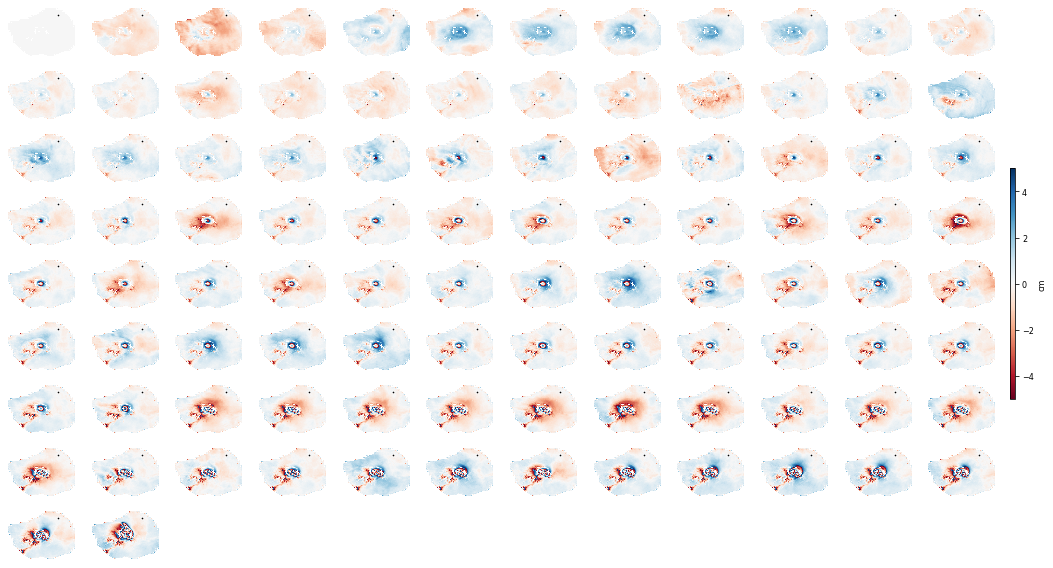

In [25]:
# View deramped time series
view.main('timeseries_ERA5_ramp.h5 --wrap --wrap-range -5 5 --notitle --notick --noaxis -c RdBu'.split())

In [26]:
# Correct phase residual caused by DEM error
!smallbaselineApp.py FernandinaSenDT128.txt --dostep correct_topography

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:15:44.310740--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - correct_topography ********************

dem_error.py /tmp/mintpy/timeseries_ERA5_ramp.h5 -t /tmp/mintpy/smallbaselineApp.cfg -o /tmp/mintpy/timeseries_ERA5_ramp_demErr.h5 --update -g /tmp/mintpy/inputs/geometryRadar.h5
read options from template file: smallbaselineApp.cfg
-----------------------------------

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is timeseries file: /tmp/mintpy/timeseries_ERA5_ramp_demErr.h5 in float32 format
file size in y/x: (450, 600)
num of datasets in file timeseries_ERA5_ramp_demErr.h5: 98
datasets to exclude (0):
[]
datasets to display (98):
['timeseries-20141213', 'timeseries-20141225', 'timeseries-20150307', 'timeseries-20150319', 'timeseries-20150331', 'timeseries-20150412', 'timeseries-20150424', 'timeseries-20150506', 'timeseries-20150518', 'timeseries-20150530', 'timeseries-20150611', 'timeseries-20150623', 'timeseries-20150717', 'timeseries-20150729', 'timeseries-20150822', 'timeseries-20150903', 'timeseries-20150915', 'timeseries-20150927', 'timeseries-20151009', 'timeseries-20151021', 'timeseries-20151102', 'timeseries-20151114', 'timeseries-20151126', 'timeseries-20151208', 'timeseries-20151220', 'timeseries-20160101', 'timeseries-20160113', 'timeseries-20160125', 'timeseries-20160206', 'timeseries-20160218', 'timeseries-20160301'

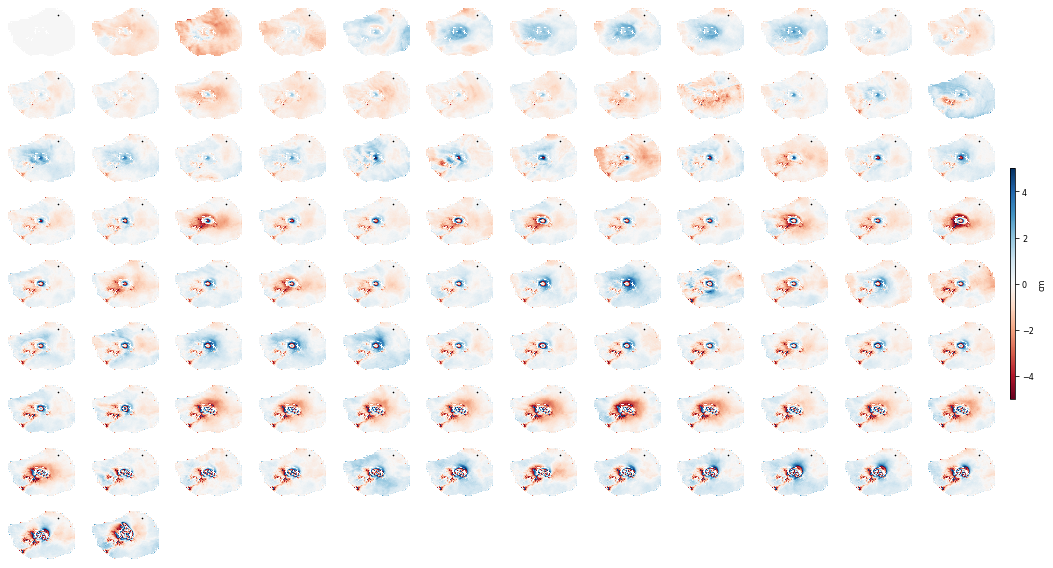

In [27]:
# View DEM error-corrected time series
view.main('timeseries_ERA5_ramp_demErr.h5 --wrap --wrap-range -5 5 --notitle --notick --noaxis -c RdBu'.split())

In [28]:
# Calculate average velocity of time series 
!smallbaselineApp.py FernandinaSenDT128.txt --dostep velocity

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:16:28.532312--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /tmp/mintpy/timeseries_ERA5_ramp_demErr.h5 -t /tmp/mintpy/smallbaselineApp.cfg -o /tmp/mintpy/velocity.h5 --update
read options from template file: smallbaselineApp.cfg
open timeseries file: timeseries_ERA5_ramp_demErr.h5
--------------------------------------------------
dates from input file: 98
['20141213',

view.py velocity.h5 --notick --noaxis --noverbose -c RdBu -v -5 5


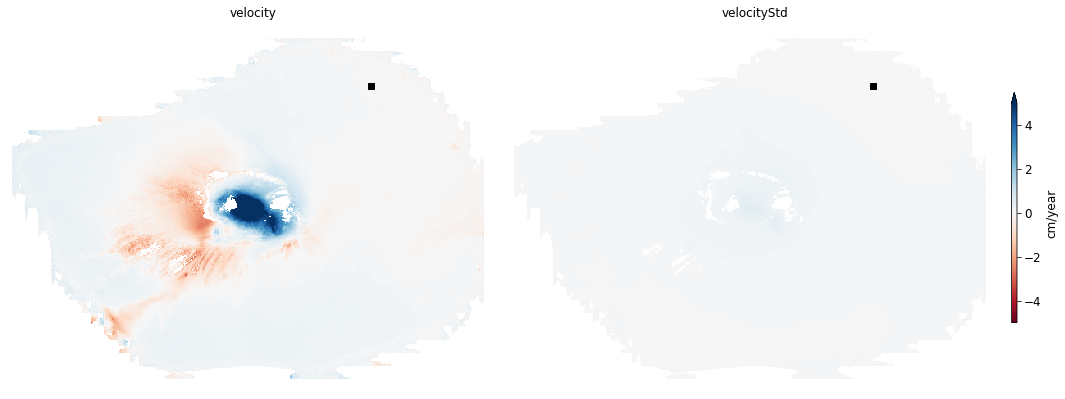

In [29]:
# View original and troposphere corrected velocities
view.main('velocity.h5 --notick --noaxis --noverbose -c RdBu -v -5 5'.split())
#view.main('velocityERA.h5 --notick --noaxis --noverbose -c RdBu -v -5 5'.split())

In [30]:
# Geocode outputs
!smallbaselineApp.py FernandinaSenDT128.txt --dostep geocode

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-03-16 22:16:32.866215--
Current directory: /tmp/mintpy
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /tmp/mintpy
read custom template file: /tmp/mintpy/FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /tmp/mintpy/smallbaselineApp.cfg
read default template file: /tmp/mintpy/smallbaselineApp.cfg


******************** step - geocode ********************

geocode.py /tmp/mintpy/inputs/geometryRadar.h5 temporalCoherence.h5 avgSpatialCoh.h5 /tmp/mintpy/timeseries_ERA5_ramp_demErr.h5 velocity.h5 -l /tmp/mintpy/inputs/geometryRadar.h5 -t /tmp/mintpy/smallbaselineApp.cfg --outdir /tmp/mintpy/geo --update
read input option from template file: /tmp/mintpy/smallbaselineApp.cfg
number of processor to be u

In [31]:
# View geocoded outputs
!ls -l ./geo

total 7792
-rw-r--r-- 1 jovyan jovyan 1110344 Mar 16 18:44 geo_avgSpatialCoh.h5
-rw-r--r-- 1 jovyan jovyan 3242803 Mar 16 18:44 geo_geometryRadar.h5
-rw-r--r-- 1 jovyan jovyan  290584 Mar 16 18:44 geo_maskTempCoh.h5
-rw-r--r-- 1 jovyan jovyan 1111432 Mar 16 18:44 geo_temporalCoherence.h5
-rw-r--r-- 1 jovyan jovyan       0 Mar 16 22:16 geo_timeseries_ERA5_ramp_demErr.h5
-rw-r--r-- 1 jovyan jovyan 2213768 Mar 16 18:44 geo_velocity.h5


run view.py in MintPy version v1.3.2, date 2021-11-21
input file is velocity file: /tmp/mintpy/geo/geo_velocity.h5 in float32 format
file size in y/x: (450, 600)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file geo_velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
data   coverage in lat/lon: (-91.70539145875654, -0.20357480635223515, -91.33854622434893, -0.5497810245555865)
subset coverage in lat/lon: (-91.70539145875654, -0.20357480635223515, -91.33854622434893, -0.5497810245555865)
------------------------------------------------------------------------
colormap: RdBu
figure title: geo_velocity
read mask from file: geo_maskTempCoh.h5
reading data ...
masking data
data    range: [-3.3682406, 9.813314] cm/year
display range: [-5.0, 5.0] cm/year
reading DEM: geo_geometryRadar.h5 ...
display data in transparency: 0.8
plot in geo-c

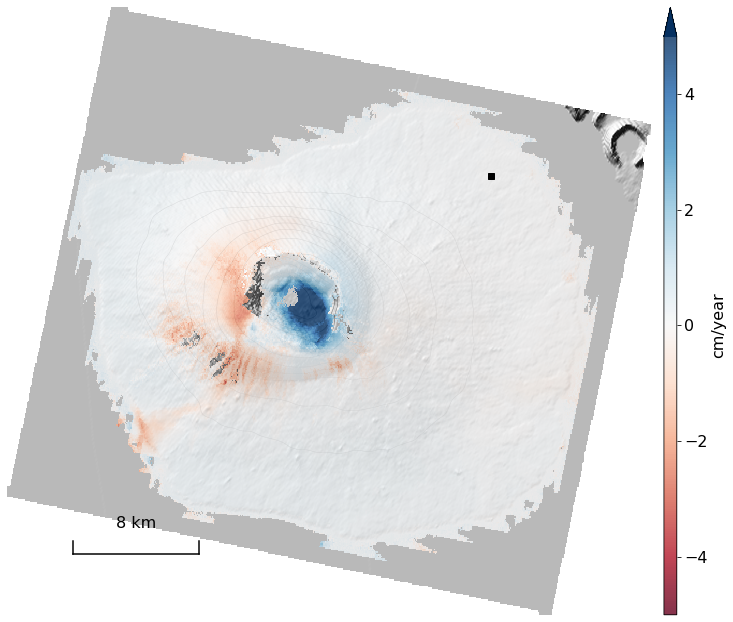

In [32]:
# Plot geocoded velocity 
view.main('./geo/geo_velocity.h5 velocity --dem ./geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis -c RdBu -v -5 5'.split())